# Loading Data & Functions #

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras
from sklearn import discriminant_analysis
from sklearn import decomposition
from sklearn.decomposition import IncrementalPCA
import numpy
from sklearn.manifold import TSNE
import tensorflow as tf             # for bulk image resize
import keras

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, MaxPool2D, SpatialDropout2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import random
import copy



import preprocessing

path = './Processed_Images_Square/'

image_dimensions = (350,350,3)


def gen_files(batch_size):
    files = glob.glob(path + '*.jpg')

    while True:
        x = []
        y = []
        for i in range(batch_size):
            f = random.choice(files)
            img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0
            img = cv2.resize(img, (image_dimensions[0], image_dimensions[1]))
            x.append(img)
            f = f.split('/')[-1]
            dog_num = float(f.split('_')[0])
            y.append(dog_num)

        yield np.array(x), np.array(y)


def gen_files_vec(batch_size):
    image_generator = gen_files(batch_size)

    while True:
        x, y = next(image_generator)


        yield vectorise(x), y

def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])


def plot_images(images, labels):
    fig = plt.figure(figsize=[15, 18])
    loop_count = 50
    if len(images) < 50:
        loop_count = len(images)
    for i in range(loop_count):
        ax = fig.add_subplot(8, 6, i + 1)
        ax.imshow(images[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(labels[i])
        ax.axis('off')


def get_siamese_data(batch_size):

    while True:
        files = glob.glob(path + '*.jpg')

        images = []
        labels = []

        for i in range(int(batch_size / 2)):
            ## Get original dog

            f = random.choice(files)
            original_dog = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0
            
            
            ## Get matching pair
            f = f.split('/')[-1]
            dog_num = f.split('_')[0]
            
            matching_breed_files = glob.glob(path + dog_num + '*.jpg')
            matching_breed_files_without_original = copy.deepcopy(matching_breed_files)
            matching_breed_files_without_original.remove(path + f)

            matching_dog = random.choice(matching_breed_files)
            pair_dog = cv2.cvtColor(cv2.imread(matching_dog), cv2.COLOR_BGR2RGB) / 255.0

            images.append((original_dog, pair_dog))
            labels.append(1.0)

            ## Get non-matching pair
            non_matching_breed_files = [x for x in files if x not in matching_breed_files]

            non_matching_dog = random.choice(non_matching_breed_files)
            non_pair_dog = cv2.cvtColor(cv2.imread(non_matching_dog), cv2.COLOR_BGR2RGB) / 255.0
            
            images.append((original_dog, non_pair_dog))
            labels.append(0.0)
            

        yield np.array(images), np.array(labels)


def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[i][0,:])
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[i][1,:])    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))



def plot_tsne(data_x, data_y):
    tsne_embeddings = TSNE(random_state=4).fit_transform(data_x)
    fig = plt.figure(figsize=[12, 12])
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = data_y.flatten());


def cmc_to_top(cmc, verbose=True):
    top1 = cmc[0]
    top5 = cmc[4]
    top10 = cmc[9]

    if verbose:
        print(f'Top 1: {top1}')
        print(f'Top 5: {top5}')
        print(f'Top 10: {top10}')

    return top1, top5, top10
    

# Load Data #

(6, 350, 350, 3)


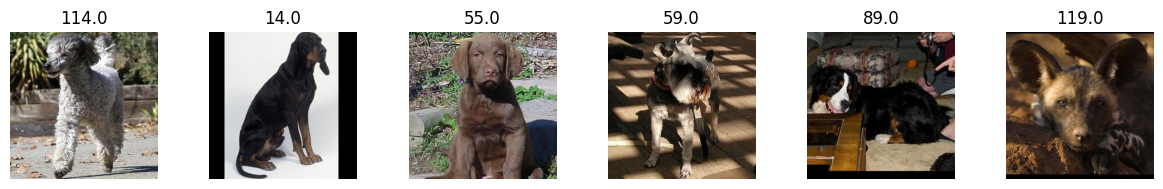

In [2]:
image_gen = gen_files(6)
images, labels = next(image_gen)
print(images.shape)

plot_images(images, labels)


In [4]:
images_pairs = get_siamese_data(20)
images, labels = next(images_pairs)
print(images.shape)
# plot_pairs(images, labels)


(20, 2, 350, 350, 3)


# PCA #

In [3]:
pca = IncrementalPCA()

In [4]:
generator_vec = gen_files_vec(50)

for i in range(5):
    print(i)
    train_X_vec, train_Y = next(generator_vec)
    pca.partial_fit(train_X_vec)


0
1
2
3
4


(500, 367500)
(500, 367500)
(500, 500)

0.14558878591792654
0.08597424900896007
0.07223691129380395
0.05390091638163442
0.04054235976364623
0.02959944760407319
0.02893826898727326
0.024730279992413673
0.020383593961626315
0.01879344979466593
0.01819489569620259
0.015045615185087124
0.01268846383693164
0.011632843312004825
0.010909879347749755
0.010609196450911594
0.009761576997415922
0.008973392693507257
0.007902291815916491
0.007185843124482335


Text(0.5, 0, 'Number of Components')

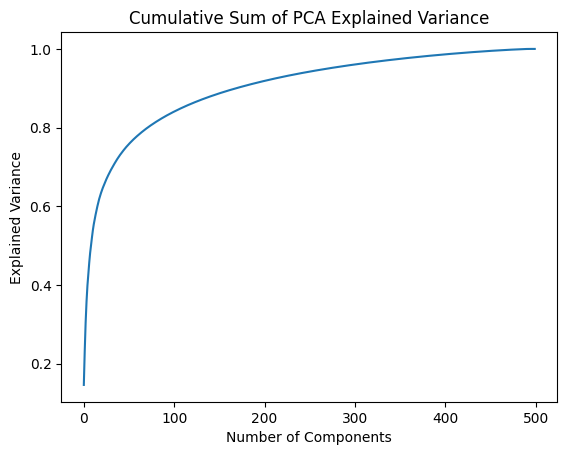

In [30]:
transformed = pca.transform(train_X_vec)
print(train_X_vec.shape)
print(pca.components_.shape)
print(transformed.shape)
print()
for i in range(20):
    print(pca.explained_variance_ratio_[i])
    
cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(pca.explained_variance_ratio_)), cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

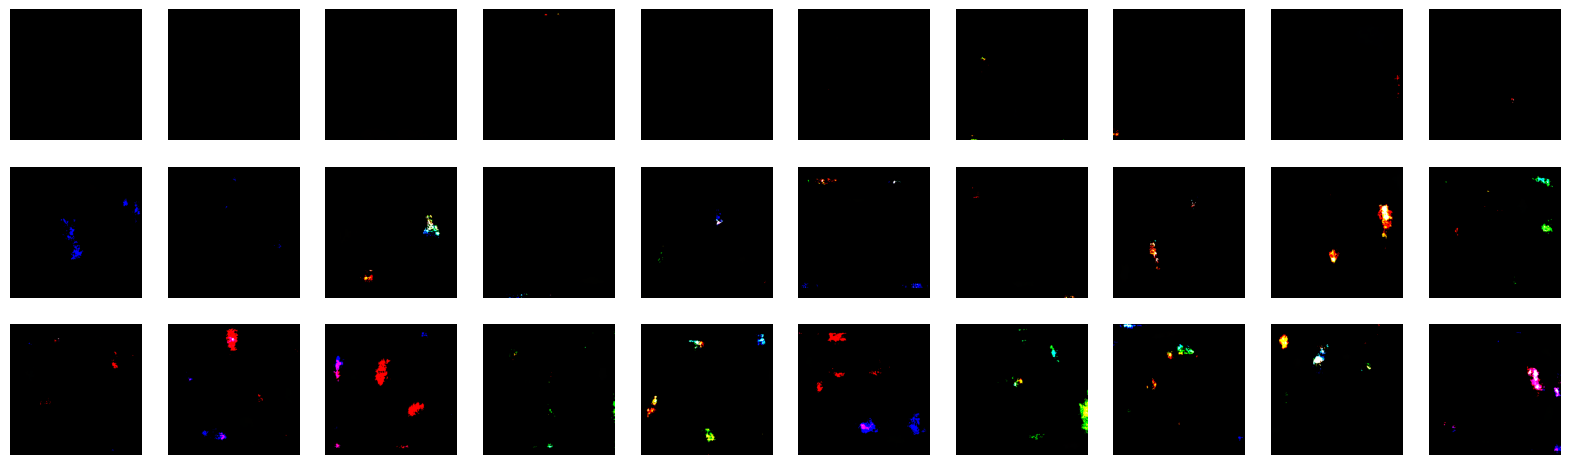

In [31]:
fig = plt.figure(figsize=[20,16])
for i in range(30):
    ax = fig.add_subplot(8, 10, i + 1)
    pc = (numpy.reshape(pca.components_[i, :], image_dimensions)*255).astype(numpy.uint8)
    ax.imshow(pc)
    ax.set_axis_off()

(500, 367500)
Data kept: 0.9748498546994843


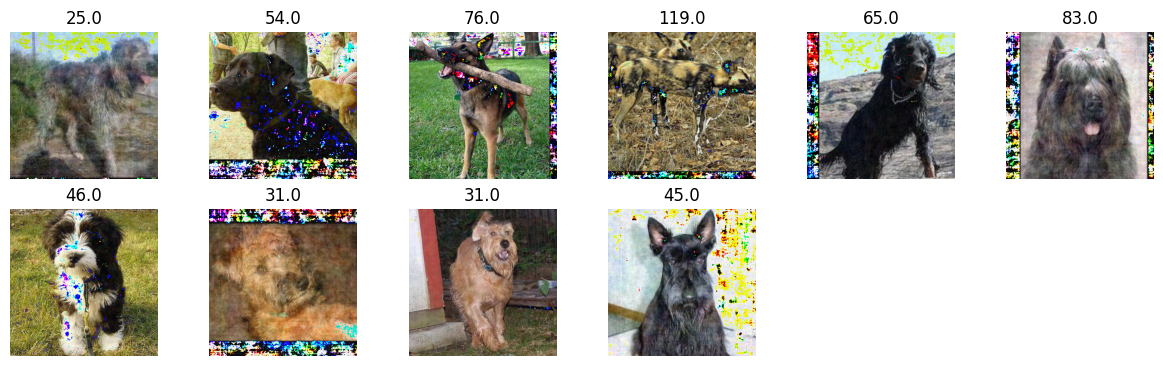

In [32]:

rows_kept = 350

reduced = transformed[:,:rows_kept]

pca_output_X_vec = reduced.dot(pca.components_[0:rows_kept,:]) + pca.mean_

print(pca_output_X_vec.shape)
print(f"Data kept: {numpy.cumsum(pca.explained_variance_ratio_)[rows_kept]}")

pca_output_X = (numpy.reshape(pca_output_X_vec, (pca_output_X_vec.shape[0], image_dimensions[0], image_dimensions[1], image_dimensions[2])) * 255).astype(numpy.uint8)

plot_images(pca_output_X[:10], train_Y[:10])

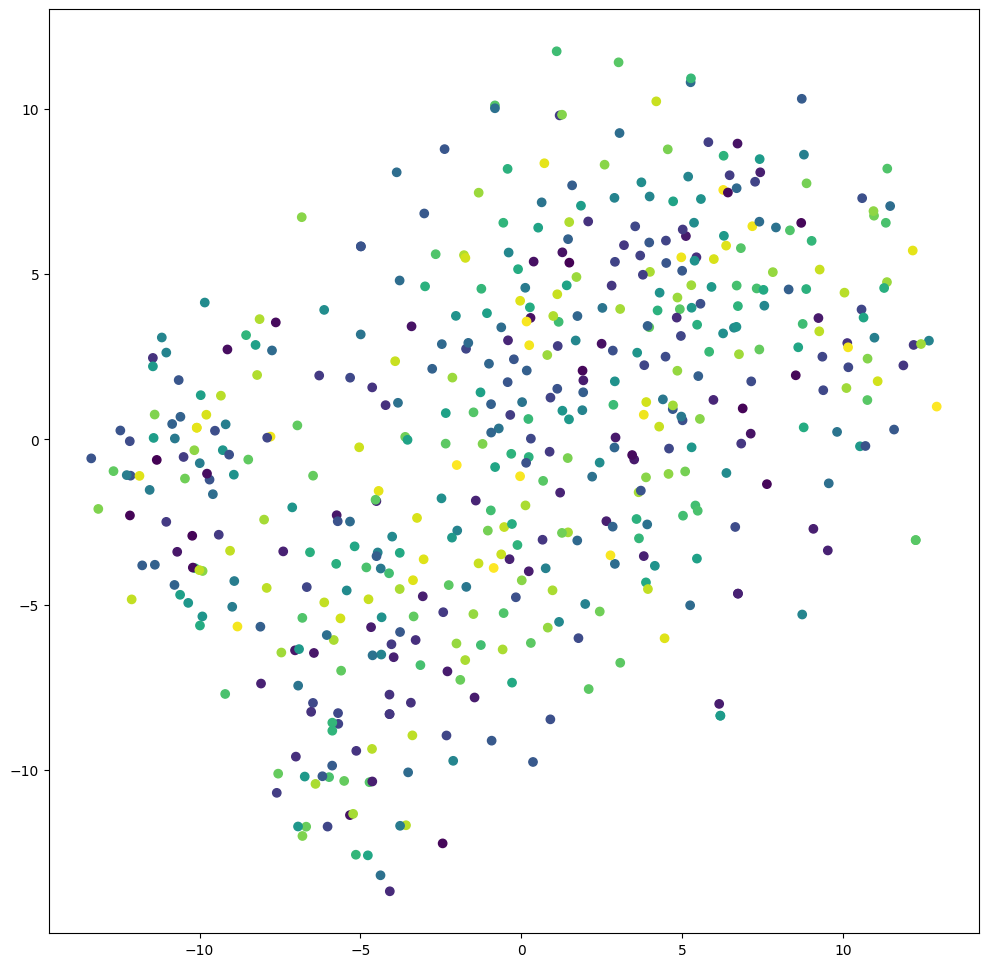

In [26]:
plot_tsne(pca_output_X_vec[:], train_Y[:])

# LDA #

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(numpy.array(train_X_vec), numpy.array(train_Y))